In [1]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# from skforecast.ForecasterAutoreg import ForecasterAutoreg

os.environ['CUDA_VISIBLE_DEVICES']='-1'
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import MultiHeadAttention
from keras.layers import LSTM
from keras.layers import Input

2024-01-05 12:06:27.844950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 12:06:27.845020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 12:06:27.897310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 12:06:28.009073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 12:06:29.092514: W tensorflow/compiler/tf2

In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/195733
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
weather_fg = fs.get_feature_group(name="weather", version=3)
query = weather_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="weather",
                                             version=3,
                                             description="Read from Weather",
                                             query=query)

In [4]:
# set up dates
train_start = "1996-02-01 22:00:00"
train_end = "2020-02-01 22:00:00"
test_start = "2020-02-01 22:00:00"
test_end = "2024-01-03 08:00:00"

# create a train-test split dataset
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end
)

Finished: Reading data from Hopsworks, using ArrowFlight (4.80s) 


In [5]:
print(X_train.columns)
print(X_test.columns)
# print(y_train.info())
# print(y_test.info())
# X_train = X_train.reset_index()
# X_test = X_test.reset_index()
X_train = X_train.set_index("date_time")
X_test = X_test.set_index("date_time")
X_train = X_train.asfreq('h')
X_test = X_test.asfreq('h')
X_train = X_train.drop(columns=["id"])
X_test = X_test.drop(columns=["id"])
print(X_train.columns)
print(X_test.columns)

Index(['date_time', 'lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur', 'id'],
      dtype='object')
Index(['date_time', 'lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur', 'id'],
      dtype='object')
Index(['lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur'],
      dtype='object')
Index(['lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur'],
      dtype='object')


In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210384 entries, 1996-02-01 22:00:00+00:00 to 2020-02-01 21:00:00+00:00
Freq: H
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   lufttemperatur             210384 non-null  float64
 1   vindriktning               210384 non-null  float64
 2   vindhastighet              210384 non-null  float64
 3   relativ_luftfuktighet      210384 non-null  float64
 4   nederbrdsmngd              210384 non-null  float64
 5   sikt                       210384 non-null  float64
 6   byvind                     210384 non-null  float64
 7   max_av_medelvindhastighet  210384 non-null  float64
 8   daggpunktstemperatur       210384 non-null  float64
dtypes: float64(9)
memory usage: 16.1 MB


In [7]:
X_train.head()

,lufttemperatur,vindriktning,vindhastighet,relativ_luftfuktighet,nederbrdsmngd,sikt,byvind,max_av_medelvindhastighet,daggpunktstemperatur
date_time,,,,,,,,,
1996-02-01 22:00:00+00:00,-7.7,252.0,1.1,98.0,0.0,31066.052812,1.8,2.7,-8.0
1996-02-01 23:00:00+00:00,-6.7,261.0,1.4,96.0,0.0,31066.225879,2.4,2.1,-7.3
1996-02-02 00:00:00+00:00,-6.2,252.0,1.1,95.0,0.0,31066.398947,1.9,1.8,-6.9
1996-02-02 01:00:00+00:00,-5.6,312.0,1.2,93.0,0.0,31066.572015,2.1,1.5,-6.6
1996-02-02 02:00:00+00:00,-5.5,289.0,0.9,94.0,0.0,31066.745083,2.3,1.4,-6.4


In [8]:
scaler = StandardScaler()
scaler.fit(X_train.values)

window_size = 24

training_window = sliding_window_view(scaler.transform(X_train.values), (window_size, 1))
training_data = training_window[:-1]
training_target = training_window[1:, :, -1]
test_window = sliding_window_view(scaler.transform(X_test.values), (window_size, 1))
test_data = test_window[:-1]
test_target = test_window[1:, :, -1]

training_data = training_data.reshape((training_data.shape[0], -1))
training_target = training_target.reshape((training_target.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))
test_target = test_target.reshape((test_target.shape[0], -1))

print(training_data.shape, training_target.shape)
print(test_data.shape, test_target.shape)
# training_data = training_data.reshape((training_data.shape[0], 1, -1))
# training_target = training_target.reshape((training_target.shape[0], 1, -1))
# test_data = test_data.reshape((test_data.shape[0], 1, -1))
# test_target = test_target.reshape((test_target.shape[0], 1, -1))
print(training_data[1, 0:24])
print(training_target[0, 0])
np.where(training_data[1] == training_target[0, 0])

(210360, 216) (210360, 9)
(34330, 216) (34330, 9)
[-1.54069061 -1.48233325 -1.41230442 -1.40063294 -1.38896147 -1.37729
 -1.37729    -1.41230442 -1.42397589 -1.40063294 -1.33060411 -1.36561853
 -1.06216026 -0.89875965 -0.85207376 -0.88708818 -0.95711701 -1.10884615
 -1.01547437 -1.01547437 -1.03881731 -1.0855032  -1.07383173 -1.07383173]
-1.0738317298685902


(array([22, 23]),)

In [9]:
print(training_data.shape)
print(training_data[1])

(210360, 216)
[-1.54069061 -1.48233325 -1.41230442 -1.40063294 -1.38896147 -1.37729
 -1.37729    -1.41230442 -1.42397589 -1.40063294 -1.33060411 -1.36561853
 -1.06216026 -0.89875965 -0.85207376 -0.88708818 -0.95711701 -1.10884615
 -1.01547437 -1.01547437 -1.03881731 -1.0855032  -1.07383173 -1.07383173
  0.8016186   0.71917978  1.26877196  1.05809496  1.38327033  1.7084457
  1.46112922 -1.58910738  0.60010147 -1.58910738 -1.58910738 -1.58910738
 -0.59068159 -0.67312041 -0.59068159 -0.67312041 -0.78303885 -0.50824276
 -0.9204369  -0.83799807 -0.6181612  -0.50824276 -0.68228028 -0.68228028
 -0.75013589 -0.90352056 -0.85239233 -1.005777   -0.90352056 -0.80126411
 -0.34111011 -1.465931   -1.05690522 -1.465931   -1.465931   -1.465931
 -0.59675122 -0.69900767 -0.23885367 -0.39223833 -0.69900767 -1.15916167
 -0.34111011 -0.34111011 -0.13659722 -0.545623   -0.64787944 -0.75013589
  0.90128809  0.84203551  0.72353034  0.78278292  0.78278292  0.78278292
  0.78278292  0.90128809  0.96054067  0.960

In [10]:
print(training_target.shape)
print(training_target[0])

(210360, 9)
[-1.07383173 -0.68228028 -0.75013589  1.07904584 -0.16295775  0.15774426
 -0.75290297 -0.8425399  -0.78243505]


In [11]:
#forecaster = ForecasterAutoreg(
#                 regressor = RandomForestRegressor(random_state=123),
#                 lags      = 6,
#             )

#reg = RandomForestRegressor(random_state=123)

#forecaster.fit(y=X_train['combine'])
#forecaster

#reg.fit(training_data, training_target)

In [12]:
# design network
model = Sequential()
model.add(Input(shape=(training_data.shape[1])))
model.add(Dense(150, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(9))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               32550     
                                                                 
 dense_1 (Dense)             (None, 100)               15100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 9)                 459       
                                                                 
Total params: 53159 (207.65 KB)
Trainable params: 53159 (207.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-01-05 12:06:46.332992: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-01-05 12:06:46.333024: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: Arch-Beast
2024-01-05 12:06:46.333031: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: Arch-Beast
2024-01-05 12:06:46.333179: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 545.29.6
2024-01-05 12:06:46.333200: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 545.29.6
2024-01-05 12:06:46.333206: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 545.29.6


Epoch 1/100
1052/1052 - 3s - loss: 0.3328 - val_loss: 0.2836 - 3s/epoch - 3ms/step
Epoch 2/100
1052/1052 - 2s - loss: 0.2598 - val_loss: 0.2467 - 2s/epoch - 2ms/step
Epoch 3/100
1052/1052 - 2s - loss: 0.2428 - val_loss: 0.2442 - 2s/epoch - 2ms/step
Epoch 4/100
1052/1052 - 2s - loss: 0.2333 - val_loss: 0.2372 - 2s/epoch - 2ms/step
Epoch 5/100
1052/1052 - 2s - loss: 0.2280 - val_loss: 0.2482 - 2s/epoch - 2ms/step
Epoch 6/100
1052/1052 - 2s - loss: 0.2281 - val_loss: 0.2347 - 2s/epoch - 2ms/step
Epoch 7/100
1052/1052 - 2s - loss: 0.2212 - val_loss: 0.2301 - 2s/epoch - 2ms/step
Epoch 8/100
1052/1052 - 2s - loss: 0.2194 - val_loss: 0.2290 - 2s/epoch - 2ms/step
Epoch 9/100
1052/1052 - 2s - loss: 0.2196 - val_loss: 0.2279 - 2s/epoch - 2ms/step
Epoch 10/100
1052/1052 - 2s - loss: 0.2161 - val_loss: 0.2289 - 2s/epoch - 2ms/step
Epoch 11/100
1052/1052 - 2s - loss: 0.2156 - val_loss: 0.2260 - 2s/epoch - 2ms/step
Epoch 12/100
1052/1052 - 2s - loss: 0.2136 - val_loss: 0.2242 - 2s/epoch - 2ms/step
E

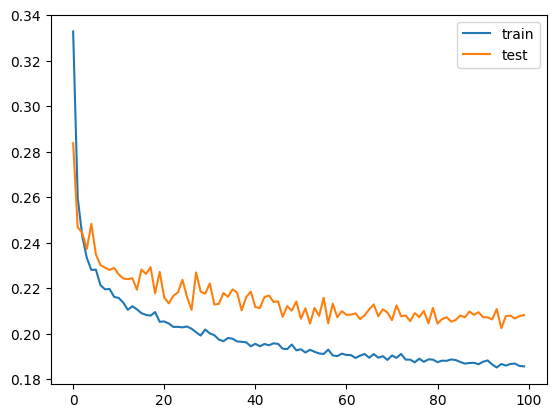

In [13]:
# fit network
history = model.fit(training_data, training_target, epochs=100, batch_size=200, validation_data=(test_data, test_target), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [14]:
#predictions = forecaster.predict(steps=4, exog=X_test.drop(columns=["lufttemperatur"]))
predictions = model.predict(test_data)
y_true = scaler.inverse_transform(test_target.reshape(predictions.shape))
y_pred = scaler.inverse_transform(predictions)
error_mse = mean_squared_error(
                 y_true = y_true,
                 y_pred = y_pred
             )
print(f"[Total] Test error (MSE): {error_mse}")
error_mse = mean_squared_error(
                 y_true = y_true[:, 0],
                 y_pred = y_pred[:, 0]
             )
print(f"[Temp] Test error (MSE): {error_mse}")

print(predictions[:5])
print(test_target[:5])
# error_mse = 0
# y_true = X_test["lufttemperatur"]
# for i in range(len(y_true)-4):
#     for s in range(4):
#         error_mse += (y_true[i+s] - predictions[i][s])**2 / (len(y_true) * 4)


1073/1073 [==============================] - 1s 776us/step
[Total] Test error (MSE): 10893225.831274714
[Temp] Test error (MSE): 1.5224744432456796
[[-0.59516907  0.9365275   0.7152378  -0.9191023  -0.1625941   1.2666101
   0.6071598   0.6394963  -0.98356056]
 [-0.575114    1.0670846   0.50230986 -0.8900789  -0.16252829  1.240046
   0.36984175  0.4646569  -0.9476423 ]
 [-0.8356496   1.0390114  -0.48211965 -0.27776104 -0.16097094  1.2160084
  -0.5516797   0.41133326 -0.9543909 ]
 [-0.8699864   1.1040274  -0.33520126 -0.12109008 -0.16255637  1.2162215
  -0.4818359  -0.13362117 -0.9480119 ]
 [-0.9581654   0.99053943 -0.31665188  0.17420198 -0.16331086  1.1897099
  -0.47983873 -0.52142894 -0.9479805 ]]
[[-0.56028696  1.09473443  0.27242856 -0.87628943 -0.16295775  1.24833109
   0.49028907  0.54843082 -0.92906939]
 [-0.66533021  1.25045222 -0.64787944 -0.63927909 -0.16295775  1.24833109
   0.25349059  0.50046631 -0.92906939]
 [-0.78204493  1.12221404 -0.34111011 -0.28376359 -0.16295775  1.2

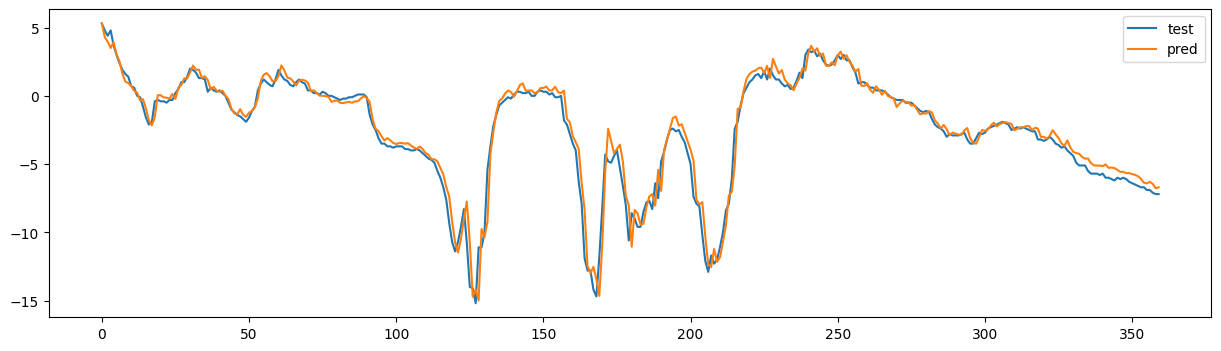

In [15]:
fig, ax = plt.subplots(figsize=(15, 4))
#training_target[:, 0].plot(ax=ax, label='train')
ax.plot(y_true[-24*15:, 0], label='test')
ax.plot(y_pred[-24*15:, 0], label='pred')
ax.legend();

In [16]:
duration = 24*2
data = scaler.transform(X_test.values)[:window_size]
runup = scaler.inverse_transform(data.copy())
for _ in range(duration):
    # window = sliding_window_view(data, (window_size, 1))
    inp = data[-window_size:].flatten('F').reshape((1, -1))
    #print("data shape", data.shape)
    #print("inp shape", inp.shape)
    res = model.predict(inp, verbose=0)
    #print("res shape", res.shape)
    data = np.concatenate((data, res), axis=0)
print("data shape", data.shape)
print("test_target shape", test_target.shape)

#y_true = scaler.inverse_transform(test_target[window_size+1:window_size+duration+1])
y_true = X_test.values[window_size:window_size+duration]
y_pred = scaler.inverse_transform(data[window_size:])

error_mse = mean_squared_error(
                 y_true = y_true,
                 y_pred = y_pred
             )
print(f"[Total] Test error (MSE): {error_mse}")
error_mse = mean_squared_error(
                 y_true = y_true[:, 0],
                 y_pred = y_pred[:, 0]
             )
print(f"[Temp] Test error (MSE): {error_mse}")

data shape (72, 9)
test_target shape (34330, 9)
[Total] Test error (MSE): 8739633.127827927
[Temp] Test error (MSE): 7.902411090546946


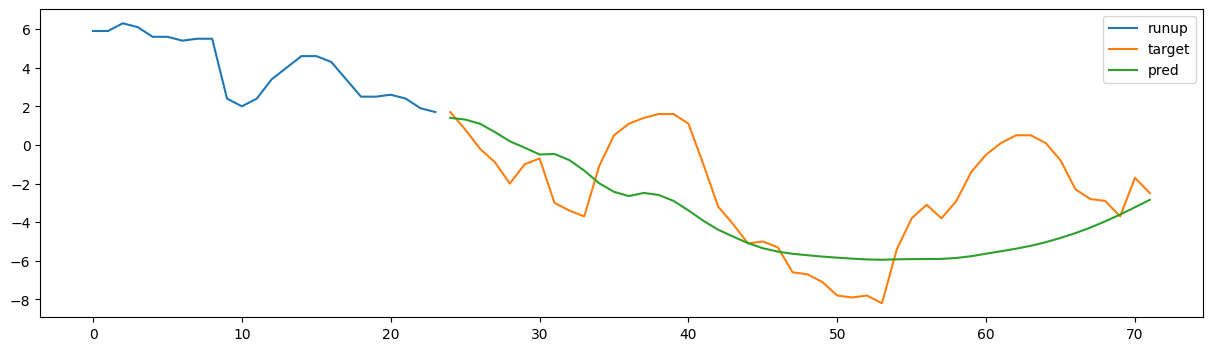

In [17]:
fig, ax = plt.subplots(figsize=(15, 4))
#training_target[:, 0].plot(ax=ax, label='train')
runup_range = range(runup.shape[0])
pred_range = range(runup.shape[0], runup.shape[0]+y_pred.shape[0])
ax.plot(runup_range, runup[:, 0], label='runup')
ax.plot(pred_range, y_true[:, 0], label='target')
ax.plot(pred_range, y_pred[:, 0], label='pred')
ax.legend();

In [19]:
mr = project.get_model_registry()

model_dir="temp_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

scaler_dir="temp_scaler"
if os.path.isdir(scaler_dir) == False:
    os.mkdir(scaler_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/temp_model.pkl")
joblib.dump(scaler, scaler_dir + "/temp_scaler.pkl")
#fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(training_data[0])
output_schema = Schema(training_target[0])
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
temp_model = mr.python.create_model(
    name="temp_model", 
    metrics={"mse" : error_mse},
    model_schema=model_schema,
    description="Temperature Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
temp_model.save(model_dir)

# Create an entry in the model registry that includes the model's name, desc, metrics
temp_scaler = mr.python.create_model(
    name="temp_scaler",
    model_schema=model_schema,
    description="Temperature Predictor Data Scaler"
)

# Upload the model to the model registry, including all files in 'model_dir'
temp_scaler.save(scaler_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 665889/665889 elapsed<00:03 remaining<00:00  2.80it/s]
Uploading: 100.000%|██████████| 207/207 elapsed<00:01 remaining<00:00<00:08,  2.01s/it]
Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.89s/it]                   


Model created, explore it at https://c.app.hopsworks.ai:443/p/195733/models/temp_model/6


Uploading: 100.000%|██████████| 815/815 elapsed<00:01 remaining<00:0000:01,  3.09it/s]
Uploading: 100.000%|██████████| 207/207 elapsed<00:01 remaining<00:00<00:05,  1.26s/it]
Model export complete: 100%|██████████| 6/6 [00:09<00:00,  1.50s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/195733/models/temp_scaler/2


Model(name: 'temp_scaler', version: 2)